# 1. Read data from csv file

In [2]:
import pandas as pd

seriea_df = pd.read_csv("season-1011_csv.csv")
seriea_df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA
0,I1,28/08/10,Roma,Cesena,0,0,D,0,0,D,...,1.84,1.76,2.10,2.02,14,-1.25,1.90,1.86,2.05,2.01
1,I1,28/08/10,Udinese,Genoa,0,1,A,0,0,D,...,2.02,1.93,1.93,1.84,23,0.00,1.75,1.68,2.23,2.12
2,I1,29/08/10,Bari,Juventus,1,0,H,1,0,H,...,2.25,2.10,1.75,1.70,17,0.00,3.00,2.72,1.50,1.41
3,I1,29/08/10,Chievo,Catania,2,1,H,1,1,D,...,2.33,2.17,1.72,1.65,21,0.00,1.63,1.54,2.55,2.40
4,I1,29/08/10,Fiorentina,Napoli,1,1,D,0,1,A,...,2.11,2.03,1.82,1.75,21,0.00,1.67,1.61,2.43,2.23


# 2. Exctracting necessary data from dataframe

In [3]:
import theano

n_games = len(seriea_df.HomeTeam.values)
games_true = round(0.6*n_games)
games_false = n_games - games_true

truefalse = [True] * games_true + [False]*games_false
truefalse = truefalse[:len(seriea_df.HomeTeam.values)]

seriea_df["played"] = truefalse

teams = seriea_df.HomeTeam.unique()
print("teams: ")
print(teams)
n_teams = len(seriea_df.HomeTeam.unique())
print("n_teams : " + str(n_teams))

teams: 
['Roma' 'Udinese' 'Bari' 'Chievo' 'Fiorentina' 'Milan' 'Palermo' 'Parma'
 'Sampdoria' 'Bologna' 'Cagliari' 'Cesena' 'Inter' 'Brescia' 'Catania'
 'Genoa' 'Juventus' 'Lazio' 'Lecce' 'Napoli']
n_teams : 20


In [4]:
team1_played, team2_played = seriea_df[seriea_df.played].HomeTeam, seriea_df[seriea_df.played].AwayTeam 
print(team1_played + " : " + team2_played)
matches_played = tuple(zip(team1_played, team2_played))

played = seriea_df[seriea_df.played]
len(played.HomeTeam.values)
not_played = seriea_df[~seriea_df.played]

0             Roma : Cesena
1           Udinese : Genoa
2           Bari : Juventus
3          Chievo : Catania
4       Fiorentina : Napoli
               ...         
223          Roma : Brescia
224    Sampdoria : Cagliari
225       Udinese : Bologna
226            Bari : Inter
227     Cagliari : Juventus
Length: 228, dtype: object


In [5]:
hometeam = theano.shared(played.HomeTeam.astype('category').cat.codes.astype('int8').values)
awayteam = theano.shared(played.AwayTeam.astype('category').cat.codes.astype('int8').values)

# 3. Making PP Model

In [6]:
import pymc3 as pm

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [hdh_nc, hdh, hdhsd, ha_nc, hah, hahsd, defense_rate_nc, defense_hyper_sd, attack_rate_nc, attack_hyper_sd, attack_hyper]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:35<00:00, 83.52draws/s] 


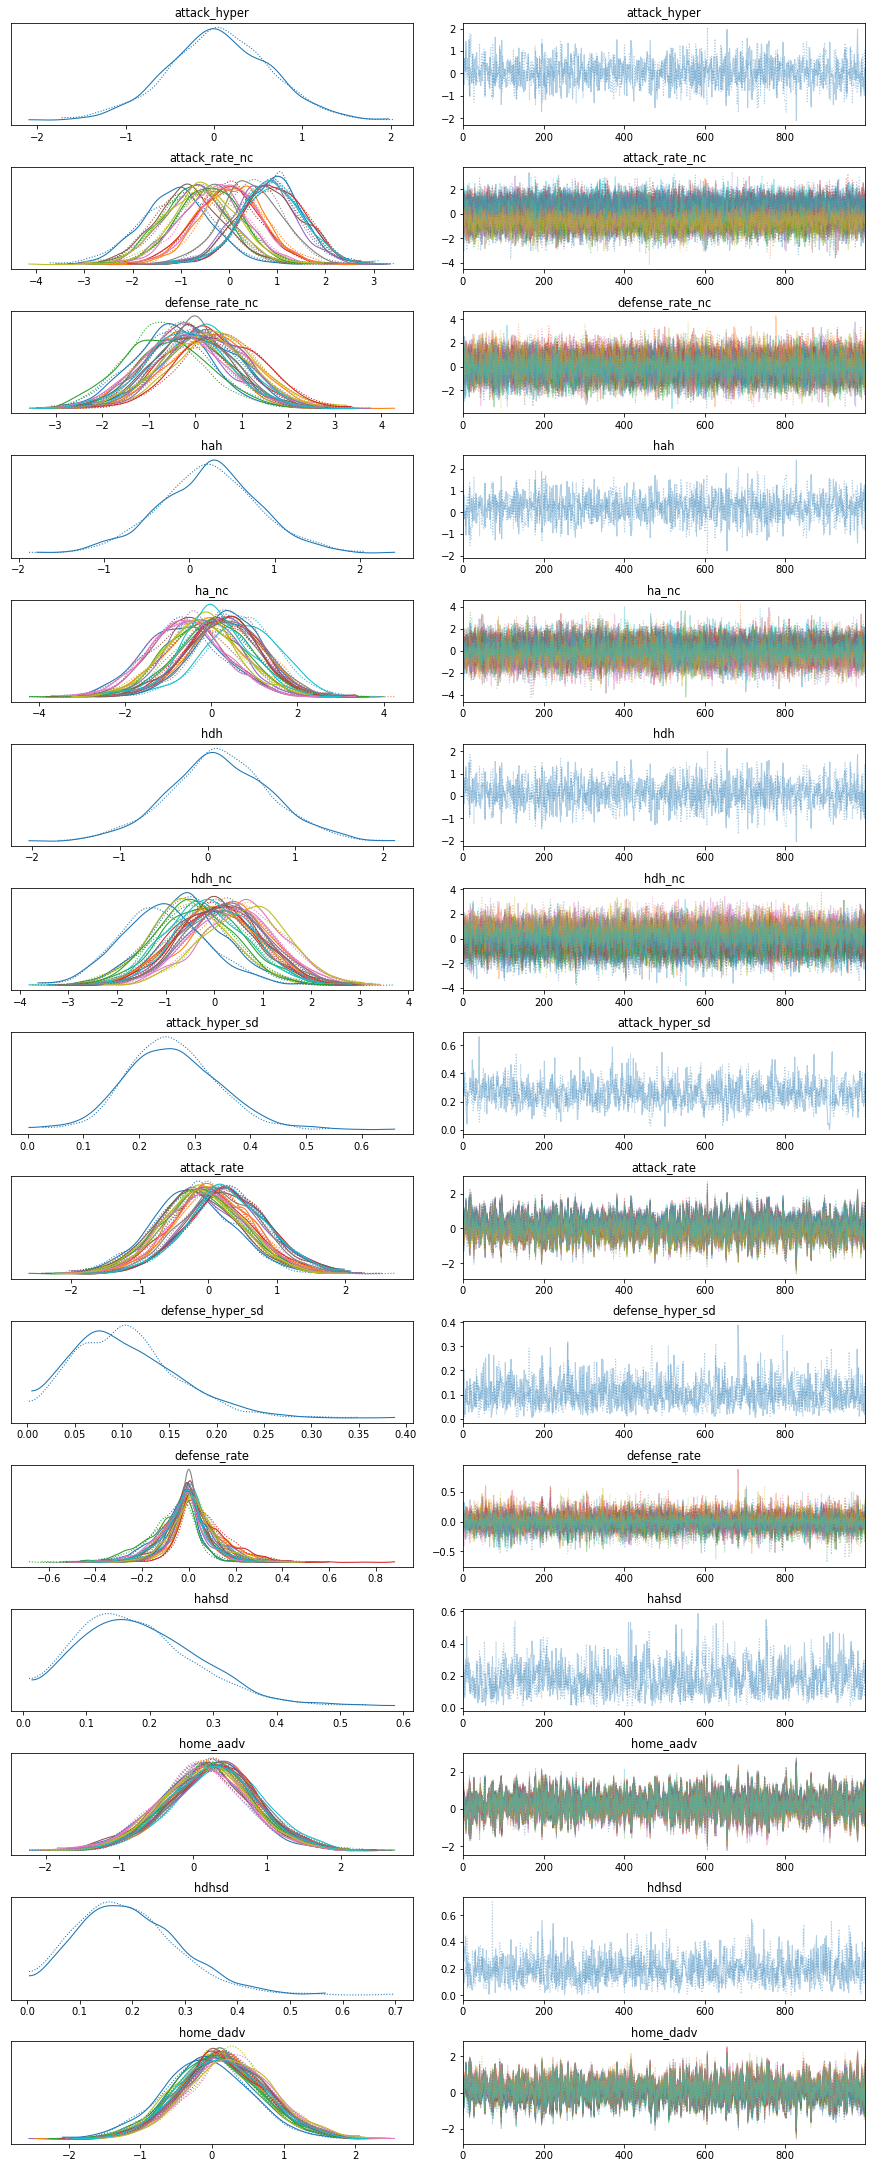

In [7]:
with pm.Model() as model:
        
        #attack rate
        attack_hyper = pm.Normal('attack_hyper', 0, 1)
        attack_hyper_sd = pm.Gamma('attack_hyper_sd', 2, 2)
        attack_rate_nc = pm.Normal('attack_rate_nc', 0, 1, shape = n_teams)
        attack_rate = pm.Deterministic('attack_rate', attack_hyper + attack_rate_nc*attack_hyper_sd)
        
        #defense rate
        defense_hyper_sd = pm.Gamma('defense_hyper_sd', 2, 2)
        defense_rate_nc = pm.Normal('defense_rate_nc', 0, 1, shape = n_teams)
        defense_rate = pm.Deterministic('defense_rate', defense_rate_nc * defense_hyper_sd)
        
        #home attack rate
        home_attack_hyper_sd = pm.Gamma('hahsd', 2, 2)
        home_attack_hyper = pm.Normal('hah', 0, 1) 
        home_attack_nc = pm.Normal('ha_nc', 0, 1, shape = n_teams)
        home_attack_advantage = pm.Deterministic('home_aadv', home_attack_hyper + home_attack_nc * home_attack_hyper_sd)
        
        #home defense rate
        home_defense_hyper_sd = pm.Gamma("hdhsd", 2, 2)
        home_defense_hyper = pm.Normal('hdh', 0, 1) 
        home_defense_nc = pm.Normal('hdh_nc', 0, 1, shape = n_teams)
        home_defense_advantage = pm.Deterministic('home_dadv', home_defense_hyper + home_defense_nc * home_defense_hyper_sd)
        
        home_diff = attack_rate[hometeam] - defense_rate[awayteam] + home_attack_advantage[hometeam] 
        away_diff = attack_rate[awayteam] - defense_rate[hometeam] - home_defense_advantage[hometeam]
        
        home_goals = pm.Poisson('home_goals', pm.math.exp(home_diff), observed = played.FTHG.values)
        away_goals = pm.Poisson('away_goals', pm.math.exp(away_diff), observed = played.FTAG.values)
        
        trace = pm.sample(1000, tune=500)
        pm.traceplot(trace)

In [8]:
post = pm.trace_to_dataframe(trace, varnames=["attack_rate", "defense_rate", "home_aadv", "home_dadv"])
post = post.stack().reset_index()
post.columns = "sample", "param", "value"

In [9]:
q = post.param.str.contains("__")
post.loc[q, "team"] = teams[post[q].param.str.split('__').str.get(-1).astype(int)] 
post["type"] = post.param.str.split('__').str.get(0)

In [10]:
post.head()

,sample,param,value,team,type
0,0,attack_rate__0,-0.595945,Roma,attack_rate
1,0,attack_rate__1,-0.389539,Udinese,attack_rate
2,0,attack_rate__2,-0.996096,Bari,attack_rate
3,0,attack_rate__3,-0.654975,Chievo,attack_rate
4,0,attack_rate__4,-0.668732,Fiorentina,attack_rate


In [11]:
labels = {
"attack_rate": "Attack rate",
"defense_rate": "Defense rate",
"home_aadv": "Home attack advantage",
"home_dadv": "Home defense advantage" }

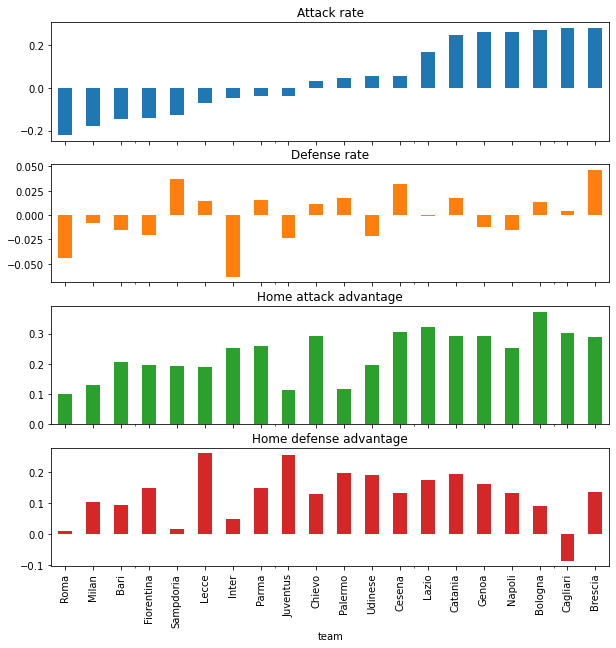

In [12]:
ax = post.groupby(['type', 'team']).value.median().unstack(0).sort_values("attack_rate").rename(columns = labels).plot.bar(subplots = True, figsize = (10, 10), legend = False) 

In [13]:
hometeam.set_value(not_played.HomeTeam.astype('category').cat.codes.astype('int8').values)
awayteam.set_value(not_played.AwayTeam.astype('category').cat.codes.astype('int8').values)

with model:
    ppc = pm.sample_ppc(trace,samples=5000)
    

<ipython-input-13-248e2c630b2b>:5: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  ppc = pm.sample_ppc(trace,samples=5000)
100%|██████████| 5000/5000 [00:19<00:00, 250.69it/s]


In [14]:
print(len(ppc["home_goals"][1]))

152


In [15]:
seriea_df.loc[~seriea_df.played, "FTAG"] = ppc["away_goals"][0]
seriea_df.loc[~seriea_df.played, "FTHG"] = ppc["home_goals"][0] 

In [16]:
seriea_df[(seriea_df.HomeTeam == "Milan") & ~seriea_df.played]

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,played
237,I1,12/02/11,Milan,Parma,0,0,H,2,0,H,...,1.93,1.90,1.84,19,-1.25,2.05,2.00,1.92,1.87,False
269,I1,28/02/11,Milan,Napoli,3,2,H,0,0,D,...,2.03,1.85,1.77,18,-0.75,2.05,2.01,1.91,1.86,False
287,I1,13/03/11,Milan,Bari,0,0,D,0,1,A,...,1.65,2.29,2.16,20,-1.50,1.75,1.70,2.26,2.19,False
301,I1,02/04/11,Milan,Inter,0,1,H,1,0,H,...,2.11,1.76,1.70,28,0.00,2.08,1.99,1.88,1.83,False
320,I1,16/04/11,Milan,Sampdoria,5,0,H,1,0,H,...,1.79,2.08,1.99,20,-1.50,2.00,1.94,1.98,1.92,False
346,I1,01/05/11,Milan,Bologna,2,1,H,1,0,H,...,1.56,2.50,2.30,18,-1.75,1.98,1.88,2.03,1.97,False
361,I1,14/05/11,Milan,Cagliari,3,2,H,3,1,H,...,1.52,2.55,2.40,21,-1.00,1.87,1.83,2.10,2.03,False


In [64]:
# simulation of final table
import numpy as np

def final_table(dataframe):

    teams = teams = dataframe.HomeTeam.unique()
    team_tuple = dict(list(tuple(zip(np.array(teams), np.zeros(len(teams), dtype='int8')))))
    
    for index, row in dataframe.iterrows():
        if row.FTHG > row.FTAG:
            team_tuple[row.HomeTeam] += 3
        elif row.FTHG < row.FTAG:
            team_tuple[row.AwayTeam] += 3
        else:
            team_tuple[row.HomeTeam] += 1
            team_tuple[row.AwayTeam] += 1
    
    team_tuple = sorted(team_tuple.items(), key=lambda x: x[1], reverse=True)
    
    for team in team_tuple:
        print(team[0] + " : " + str(team[1]))
    
    return team_tuple
        
            
            
print("simulated final table: ")
final_table_sim = final_table(seriea_df)

real_seriea_df = pd.read_csv("season-1011_csv.csv")
print("\nreal final table: ")
final_table_real = final_table(real_seriea_df)

simulated final table: 
Roma : 74
Milan : 72
Inter : 69
Juventus : 68
Lazio : 62
Napoli : 62
Genoa : 60
Udinese : 57
Palermo : 53
Bologna : 53
Fiorentina : 50
Sampdoria : 50
Cagliari : 49
Catania : 42
Chievo : 41
Parma : 39
Lecce : 39
Bari : 33
Cesena : 31
Brescia : 31

real final table: 
Milan : 82
Inter : 76
Napoli : 70
Udinese : 66
Lazio : 66
Roma : 63
Juventus : 58
Palermo : 56
Fiorentina : 51
Genoa : 51
Chievo : 46
Parma : 46
Catania : 46
Bologna : 45
Cagliari : 45
Cesena : 43
Lecce : 41
Sampdoria : 36
Brescia : 32
Bari : 24


# MSE

In [77]:
dataframe1 = seriea_df.tail(games_false)
dataframe2 = real_seriea_df.tail(games_false)

def mse(dataframe1, dataframe2,teams):
    
    MSE_all = 0
    
    for team in teams:
        
        compare1 = dataframe1[dataframe1.HomeTeam == team]
        compare2 = dataframe2[dataframe2.HomeTeam == team]
        
        Y_pred_home = compare1.FTHG.values
        Y_true_home = compare2.FTHG.values
        
        Y_pred_away = compare1.FTAG.values
        Y_true_away = compare2.FTAG.values
        
        MSE = np.square(np.subtract(Y_true_home,Y_pred_home) + np.subtract(Y_true_away,Y_pred_away)).mean()
        MSE_all += MSE
        print(team + " MSE: " + str(MSE))
    
    print("\nMSE for all teams: " + str(MSE_all))
    
mse(dataframe1, dataframe2, teams)  

Roma MSE: 7.625
Udinese MSE: 8.75
Bari MSE: 6.0
Chievo MSE: 1.8571428571428572
Fiorentina MSE: 6.125
Milan MSE: 5.142857142857143
Palermo MSE: 6.571428571428571
Parma MSE: 2.7142857142857144
Sampdoria MSE: 10.625
Bologna MSE: 4.333333333333333
Cagliari MSE: 3.4285714285714284
Cesena MSE: 5.571428571428571
Inter MSE: 5.75
Brescia MSE: 6.625
Catania MSE: 5.857142857142857
Genoa MSE: 4.75
Juventus MSE: 9.375
Lazio MSE: 7.428571428571429
Lecce MSE: 10.25
Napoli MSE: 6.125

MSE for all teams: 124.90476190476191
